<a href="https://colab.research.google.com/github/KeerthanaSistla/ML/blob/main/MLAssignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Mammographic Masses

In [14]:
import pandas as pd
import numpy as np

# Load data
data_path = '/content/mammographic_masses.data'
columns = ['BI-RADS', 'Age', 'Shape', 'Margin', 'Density', 'Severity']
df = pd.read_csv(data_path, names=columns, na_values='?')

# Check the first few rows
print(df.head())

# Check missing values
print(df.isna().sum())

   BI-RADS   Age  Shape  Margin  Density  Severity
0      5.0  67.0    3.0     5.0      3.0         1
1      4.0  43.0    1.0     1.0      NaN         1
2      5.0  58.0    4.0     5.0      3.0         1
3      4.0  28.0    1.0     1.0      3.0         0
4      5.0  74.0    1.0     5.0      NaN         1
BI-RADS      2
Age          5
Shape       31
Margin      48
Density     76
Severity     0
dtype: int64


In [15]:
from sklearn.preprocessing import LabelEncoder

# Fill missing values
for col in df.columns:
    if df[col].dtype == 'object':
        df[col].fillna(df[col].mode()[0], inplace=True)
    else:
        df[col].fillna(df[col].median(), inplace=True)

# Encode categorical features
cat_cols = ['BI-RADS', 'Shape', 'Margin', 'Density']
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

# Features and target
X = df.drop('Severity', axis=1)
y = df['Severity']
print(X.head())
print(y.value_counts())

   BI-RADS   Age  Shape  Margin  Density
0        4  67.0      2       4        2
1        3  43.0      0       0        2
2        4  58.0      3       4        2
3        3  28.0      0       0        2
4        4  74.0      0       4        2
Severity
0    516
1    445
Name: count, dtype: int64


/tmp/ipython-input-36065780.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


In [16]:
from sklearn.metrics import confusion_matrix, recall_score, f1_score, precision_score

def evaluate_model(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = cm.ravel()
    acc_plus = recall_score(y_true, y_pred)
    acc_minus = TN / (TN + FP)
    precision = precision_score(y_true, y_pred)
    f_measure = f1_score(y_true, y_pred)
    g_mean = np.sqrt(acc_plus * acc_minus)
    wt_accuracy = (acc_plus + acc_minus) / 2
    return {
        "Acc+": round(acc_plus*100,2),
        "Acc-": round(acc_minus*100,2),
        "Precision": round(precision*100,2),
        "F-measure": round(f_measure*100,2),
        "G-mean": round(g_mean*100,2),
        "Wt. Accuracy": round(wt_accuracy*100,2)
    }

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

#Weighted Random Forest (W=1:2)

In [18]:
from sklearn.ensemble import RandomForestClassifier

wrf2 = RandomForestClassifier(
    n_estimators=300,
    class_weight={0:1, 1:2},  # minority class weighted
    random_state=42,
    max_depth=None
)

wrf2.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 1, 1: 2}, n_estimators=300,
                       random_state=42)

In [19]:
from sklearn.metrics import confusion_matrix, recall_score, f1_score, precision_score

y_prob = wrf2.predict_proba(X_test)[:,1]
thresholds = np.arange(0.1, 0.9, 0.01)

best_gmean = 0
best_threshold = 0.5
best_pred = None

for t in thresholds:
    y_pred = (y_prob >= t).astype(int)
    metrics = evaluate_model(y_test, y_pred)
    if metrics["G-mean"] > best_gmean:
        best_gmean = metrics["G-mean"]
        best_threshold = t
        best_pred = y_pred

final_metrics = evaluate_model(y_test, best_pred)
print(f"Best Threshold: {best_threshold}")
print("Performance Metrics:")
for k,v in final_metrics.items():
    print(f"{k}: {v}")

Best Threshold: 0.6099999999999998
Performance Metrics:
Acc+: 80.3
Acc-: 85.35
Precision: 82.17
F-measure: 81.23
G-mean: 82.79
Wt. Accuracy: 82.83


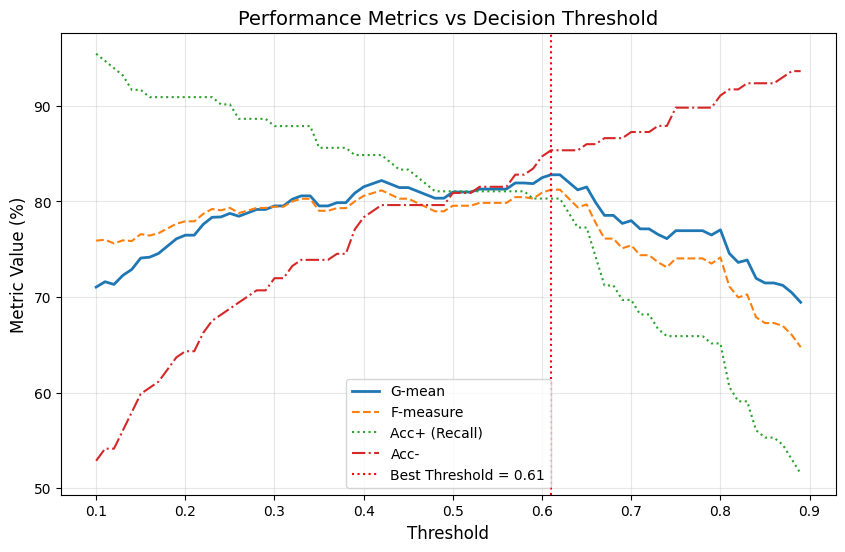

In [20]:
import matplotlib.pyplot as plt

# Store all metrics for visualization
results = []
for t in thresholds:
    y_pred = (y_prob >= t).astype(int)
    m = evaluate_model(y_test, y_pred)
    results.append({
        "Threshold": t,
        "G-mean": m["G-mean"],
        "F-measure": m["F-measure"],
        "Acc+": m["Acc+"],
        "Acc-": m["Acc-"]
    })

# Convert to DataFrame
metrics_df = pd.DataFrame(results)

# Plot
plt.figure(figsize=(10,6))
plt.plot(metrics_df["Threshold"], metrics_df["G-mean"], label="G-mean", linewidth=2)
plt.plot(metrics_df["Threshold"], metrics_df["F-measure"], label="F-measure", linestyle="--")
plt.plot(metrics_df["Threshold"], metrics_df["Acc+"], label="Acc+ (Recall)", linestyle=":")
plt.plot(metrics_df["Threshold"], metrics_df["Acc-"], label="Acc-", linestyle="-.")
plt.axvline(best_threshold, color='red', linestyle=':', label=f"Best Threshold = {best_threshold:.2f}")

plt.title("Performance Metrics vs Decision Threshold", fontsize=14)
plt.xlabel("Threshold", fontsize=12)
plt.ylabel("Metric Value (%)", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

#Weighted Random Forest (W=1:3)

In [21]:
from sklearn.ensemble import RandomForestClassifier

wrf3 = RandomForestClassifier(
    n_estimators=300,
    class_weight={0:1, 1:3},  # minority class weighted
    random_state=42,
    max_depth=None
)

wrf3.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 1, 1: 3}, n_estimators=300,
                       random_state=42)

In [22]:
y_prob = wrf3.predict_proba(X_test)[:,1]
thresholds = np.arange(0.1, 0.9, 0.01)

best_gmean = 0
best_threshold = 0.5
best_pred = None

for t in thresholds:
    y_pred = (y_prob >= t).astype(int)
    metrics = evaluate_model(y_test, y_pred)
    if metrics["G-mean"] > best_gmean:
        best_gmean = metrics["G-mean"]
        best_threshold = t
        best_pred = y_pred

final_metrics = evaluate_model(y_test, best_pred)
print(f"Best Threshold: {best_threshold}")
print("Performance Metrics:")
for k,v in final_metrics.items():
    print(f"{k}: {v}")

Best Threshold: 0.5999999999999998
Performance Metrics:
Acc+: 79.55
Acc-: 84.08
Precision: 80.77
F-measure: 80.15
G-mean: 81.78
Wt. Accuracy: 81.81


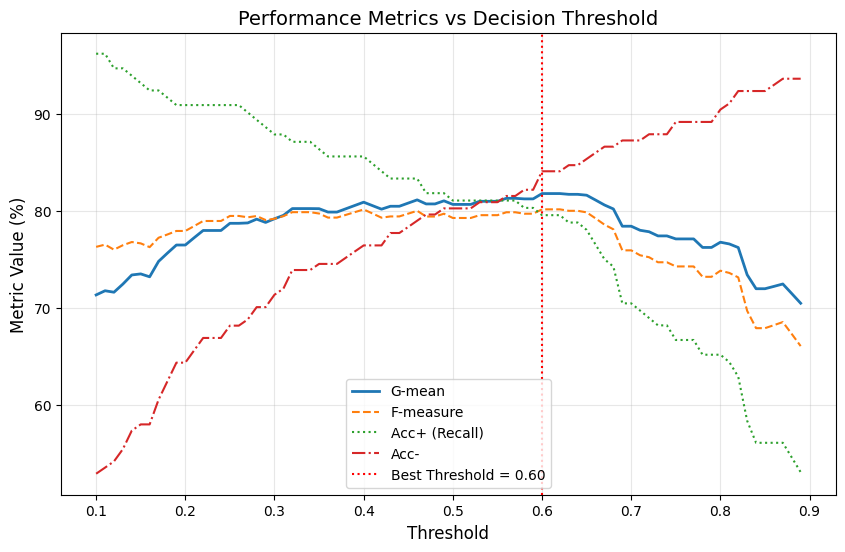

In [23]:
import matplotlib.pyplot as plt

# Store all metrics for visualization
results = []
for t in thresholds:
    y_pred = (y_prob >= t).astype(int)
    m = evaluate_model(y_test, y_pred)
    results.append({
        "Threshold": t,
        "G-mean": m["G-mean"],
        "F-measure": m["F-measure"],
        "Acc+": m["Acc+"],
        "Acc-": m["Acc-"]
    })

# Convert to DataFrame
metrics_df = pd.DataFrame(results)

# Plot
plt.figure(figsize=(10,6))
plt.plot(metrics_df["Threshold"], metrics_df["G-mean"], label="G-mean", linewidth=2)
plt.plot(metrics_df["Threshold"], metrics_df["F-measure"], label="F-measure", linestyle="--")
plt.plot(metrics_df["Threshold"], metrics_df["Acc+"], label="Acc+ (Recall)", linestyle=":")
plt.plot(metrics_df["Threshold"], metrics_df["Acc-"], label="Acc-", linestyle="-.")
plt.axvline(best_threshold, color='red', linestyle=':', label=f"Best Threshold = {best_threshold:.2f}")

plt.title("Performance Metrics vs Decision Threshold", fontsize=14)
plt.xlabel("Threshold", fontsize=12)
plt.ylabel("Metric Value (%)", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [24]:
diff = np.abs(wrf2.predict_proba(X_test)[:,1] - wrf3.predict_proba(X_test)[:,1])
print("Max difference in predicted probabilities:", diff.max())


Max difference in predicted probabilities: 0.07999999999999996
